# Bubble Analysis

## Abstract

Analyze Hass Door part numbers of complete doors where at least one section presented a buble caused by the expansion of gas trapped between the exterior skin and foam.

## Data

Data will be imported from Microsoft Excel files in the following format:

![alt text](assets/image.png)

The file can contain multiple sheets and all sheets will be imported and concatinated if `use_all_sheets = True`.

Columns can be added to the data by modifying `columns = ['Line', 'Blend','EndOfPourTimeStamp', 'SmartPartNumber', 'Order Number']`.

### Open XLSX and Convert to CSV


In [1]:
import xlsx_to_csv as xtc

files = ['order_history.xlsx', 'orders_with_bubbles.xlsx', 'sections_with_bubbles.xlsx']
columns = ['Order', 'Serial', 'SmartPartNumber', 'Line', 'Blend', 'EndOfPourTimeStamp']
overwrite_existing = False
use_all_sheets = True

# convert the XLSX file to CSV
for file in files:
    csv_file = xtc.xls_to_csv(file, columns, overwrite_existing, use_all_sheets)

order_history.csv already exists!
orders_with_bubbles.csv has been created.
sections_with_bubbles.csv has been created.


In [5]:
import pandas as pd
import haas_section as hs
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("Loading data . . .")
df = pd.read_csv(csv_file)

# disect the part number and make columns for each definition
for option, loc in hs.ht_part_number.items():
    df[option] = df['SmartPartNumber'].str[loc[0]:loc[1]]

# df.to_csv("bubbles.csv")

# # convert EndOfPourTimeStamp into date/time object
# # then make Year, Month and Day and Hour columns
df['EndOfPourTimeStamp'] = pd.to_datetime(df['EndOfPourTimeStamp'])
df['EndOfPourTimeStamp'] = df['EndOfPourTimeStamp'].dt.round(freq='15min')
df['Weekday'] = df['EndOfPourTimeStamp'].dt.weekday
df['Year'] = df['EndOfPourTimeStamp'].dt.year
df['Month'] = df['EndOfPourTimeStamp'].dt.month
df['Hour'] = df['EndOfPourTimeStamp'].dt.hour
# df['Time'] = df['EndOfPourTimeStamp'].dt.time

df.to_csv("bubbles.csv")

firstDate, lastDate = df['EndOfPourTimeStamp'].min(), df['EndOfPourTimeStamp'].max()
print(f'From {firstDate} to {lastDate}')

# delete the original EndOfPourTimeStamp 
df.drop('EndOfPourTimeStamp', axis=1, inplace=True)
# delete the SmartPartNumber 
df.drop('SmartPartNumber', axis=1, inplace=True)
# delete the Order Number 
df.drop('Order Number', axis=1, inplace=True)

df.to_csv("bubbles.csv")

df_shape = df.shape
df.dropna(inplace=True)
df_new_shape = df.shape

dropped_rows = df_shape[0] - df_new_shape[0]
print(f'*{dropped_rows} rows were dropped due to incomplete data.')

# remove uniform columns
uniform_columns = [col for col in df.columns if df[col].nunique() == 1]
print(str(uniform_columns) + " contain homogeneous data and have been removed.")
df = df.drop(columns=uniform_columns)

# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to all categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Calculate Pearson correlation (default)
pearson_corr = df.corr()

# Calculate Spearman correlation
spearman_corr = df.corr(method='spearman')

# Calculate Kendall correlation
kendall_corr = df.corr(method='kendall')

correlation_matrix = pearson_corr

# Print the correlation matrix
print(correlation_matrix)

Loading data . . .
From 2019-10-21 22:45:00 to 2024-07-17 09:30:00
*0 rows were dropped due to incomplete data.
['Inside Grooving'] contain homogeneous data and have been removed.
                            Line     Blend      Type    Height  Construction  \
Line                    1.000000  0.004871  0.052359  0.217113      0.208281   
Blend                   0.004871  1.000000 -0.024390  0.096989      0.190824   
Type                    0.052359 -0.024390  1.000000  0.052751     -0.016853   
Height                  0.217113  0.096989  0.052751  1.000000      0.079015   
Construction            0.208281  0.190824 -0.016853  0.079015      1.000000   
Color                   0.102319 -0.111611  0.048486  0.041219     -0.241815   
Thickness              -0.260381  0.147529 -0.043084  0.122532     -0.217239   
Outside Skin           -0.268211  0.012689  0.015660 -0.229663      0.007297   
Outside Treatment       0.345905  0.131426  0.114819  0.453668      0.106580   
Outside Grooving    

The correlation matrix will contain the Pearson correlation coefficients between each pair of variables. A value closer to 1 indicates a strong positive relationship, while values closer to -1 indicate a strong negative relationship. Values close to zero suggest no linear relationship between two variables.


In [41]:
# Identify the most correlated variables
most_correlated_variables = correlation_matrix.unstack().sort_values(ascending=False)[1:]

# Print the most correlated variables
print('Most correlated variables:')
print(most_correlated_variables)

Most correlated variables:
Line                    Line                      1.000000
Year                    Year                      1.000000
Weekday                 Weekday                   1.000000
Inside Skin             Inside Skin               1.000000
Outside Grooving        Outside Grooving          1.000000
                                                    ...   
Length                  End Stiles               -0.298847
                        Backer Stile Placement   -0.348689
Backer Stile Placement  Length                   -0.348689
                        Construction             -0.483030
Construction            Backer Stile Placement   -0.483030
Length: 323, dtype: float64


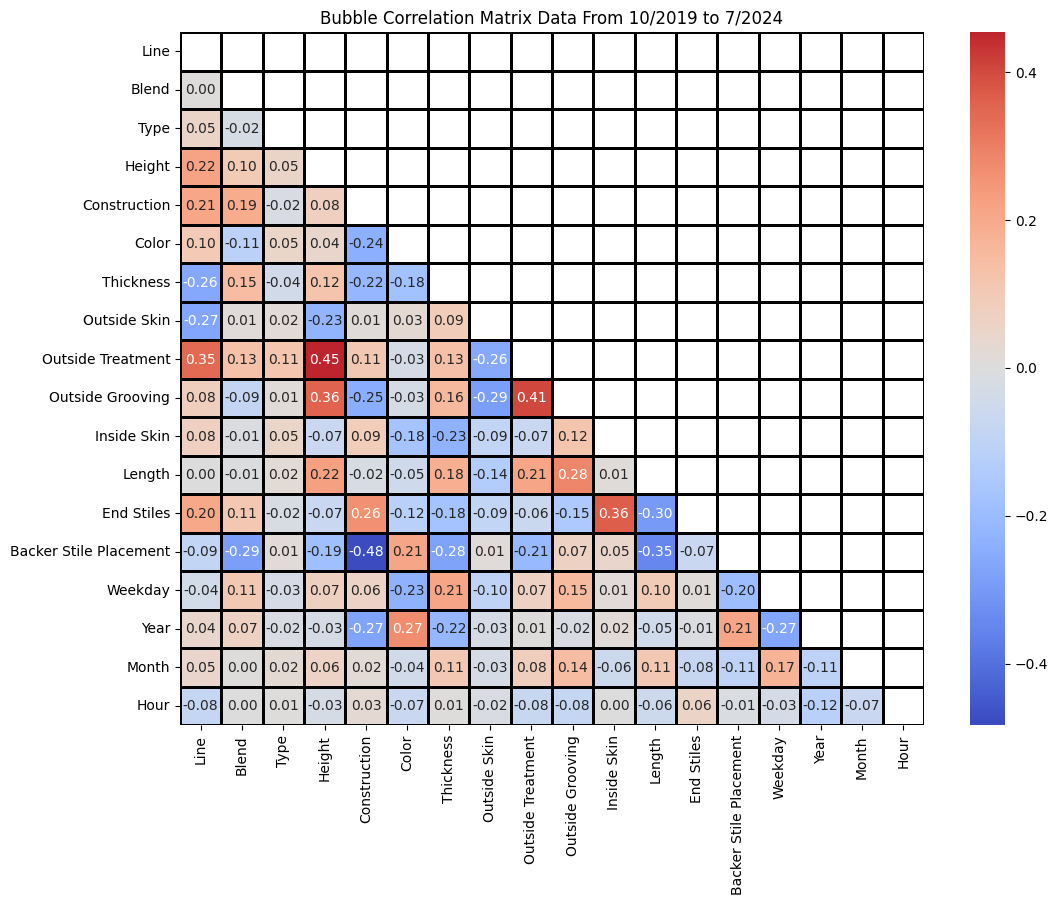

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 9))
matrix = np.triu(df.corr())
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            cbar=True, 
            fmt=".2f",
            center=0,
            linewidths=2, 
            linecolor='black',
            mask=matrix
            )

# Add a title
plt.title(f'Bubble Correlation Matrix Data From {firstDate.month}/{firstDate.year} to {lastDate.month}/{lastDate.year}')

# Show the plot
plt.show()

In [38]:
pd.unique(df['Color'])

pd.value_counts(df['Color'])



C:\Users\mrupp\AppData\Local\Temp\ipykernel_18912\1050050563.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['Color'])


Color
8     1422
15    1370
11    1107
5      337
12     262
3      234
10     196
16     141
4      139
0       80
6       59
13      32
7       25
1       16
14      12
2        8
9        5
Name: count, dtype: int64

In [9]:
import pandas as pd

print(df['Color'])

# Label encoding
df['encoded_Color'] = df['Color'].astype('category').cat.codes

# Create a mapping dictionary
mapping = dict(enumerate(df['Color'].astype('category').cat.categories))

# Reverse the encoding
df['decoded_color'] = df['encoded_Color'].map(mapping)

print(df)

0        3
1        3
2        3
3        3
4        3
        ..
5440    15
5441    15
5442    15
5443    15
5444    15
Name: Color, Length: 5445, dtype: int64
      Line  Blend  Type  Height  Construction  Color  Thickness  Outside Skin  \
0        1      7     0       2             4      3          2             0   
1        1      7     1       2             4      3          2             0   
2        1      7     1       2             4      3          2             0   
3        1      7     1       2             4      3          2             0   
4        1      7     1       2             4      3          2             0   
...    ...    ...   ...     ...           ...    ...        ...           ...   
5440     1     16     1       2             0     15          0             0   
5441     1     16     1       2             0     15          0             0   
5442     1     16     1       2             0     15          0             0   
5443     1     16     1      